<a href="https://colab.research.google.com/github/LanceAlcala/CPEN-research/blob/main/Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [552]:
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from enum import auto
import io
import time
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def get_space_consumption(obj):
    memory_usage = sys.getsizeof(obj)
    frame = sys._getframe()
    while frame:
        memory_usage += sys.getsizeof(frame.f_locals) + sys.getsizeof(frame.f_globals)
        frame = frame.f_back
    memory_usage_kb = memory_usage / 1024
    return memory_usage_kb

# Dataset

In [553]:
dataset = pd.read_csv("/content/dataset.csv")
dataset.head(4500)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,15,1,1,1,1,1,6,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,15,1,1,19,1,1,10,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,12,1,1,1,22,27,10,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9,1,1,1,22,27,8,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


In [554]:
specific_word = 'Enrolled'
condition = np.logical_not(np.any(dataset == specific_word, axis=1))
rows_removed = len(dataset) - np.sum(condition)
filtered_dataset = dataset[condition]
print("There are",rows_removed, "rows removed.")
filtered_dataset.head(4425)

There are 794 rows removed.


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,15,1,1,1,1,1,6,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,15,1,1,19,1,1,10,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,12,1,1,1,22,27,10,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9,1,1,1,22,27,8,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


In [555]:
y = filtered_dataset['Target']
del filtered_dataset['Target']
X = filtered_dataset.values

K means clustering

In [556]:
kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(X)
cluster_labels = kmeans.labels_

Train dataset

In [557]:
X_train, X_test, y_train, y_test, train_labels, test_labels = train_test_split(
    X, y, cluster_labels, test_size=0.2, random_state=42
)
k = 20
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

Finding the optimal n for KNN

Minimum error:- 0.17355371900826447 at K = 6


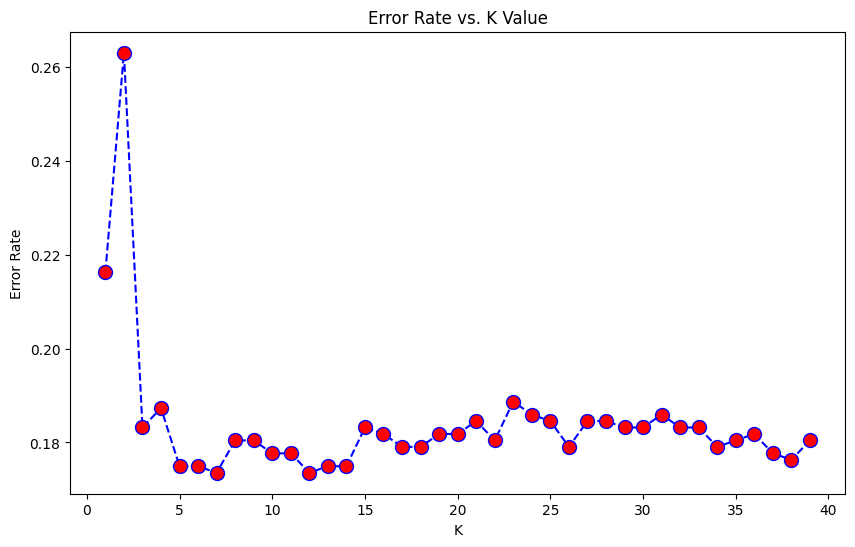

In [558]:
error_rate = []
for i in range(1,40):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed',
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

# Models

In [559]:
knn = KNeighborsClassifier(n_neighbors=6)
dnn = MLPClassifier(activation= 'relu',alpha= 0.004558327528535912, solver = 'adam', hidden_layer_sizes=(50, 50),learning_rate_init=0.04692488919658672)
voting_classifier = VotingClassifier(estimators=[('knn', knn), ('dnn', dnn)],voting='hard')

# Train Model

In [560]:
knnt0 = time.time()
knn.fit(X_train, y_train)
knnt1 = time.time()
print("KNN training took {:.3f}s".format(knnt1 - knnt0))


dnnt0 = time.time()
dnn.fit(X_train, y_train)
dnnt1 = time.time()
print("DNN training took {:.3f}s".format(dnnt1 - dnnt0))



hvt0 = time.time()
voting_classifier.fit(X_train, y_train)
hvt1 = time.time()
print("Hard Voting Ensemble training took {:.3f}s".format(hvt1 - hvt0))



KNN training took 0.006s
DNN training took 0.956s
Hard Voting Ensemble training took 1.344s


# Prediction

In [561]:
knnpt0 = time.time()
y_pred_KNN = knn.predict(X_test)
knnpt1 = time.time()


dnnpt0 = time.time()
y_pred_DNN = dnn.predict(X_test)
dnnpt1 = time.time()


hvpt0 = time.time()
y_pred_HV = voting_classifier.predict(X_test)
hvpt1 = time.time()


# Evaluation

1. Accuracy

In [562]:
knn_accuracy = accuracy_score(y_test, y_pred_KNN)
dnn_accuracy = accuracy_score(y_test, y_pred_DNN)
ensemble_accuracy = accuracy_score(y_test, y_pred_HV)

2. Precision

In [563]:
knn_precision = precision_score(y_test, y_pred_KNN, average='weighted')
dnn_precision = precision_score(y_test, y_pred_DNN, average='weighted')
ensemble_precision = precision_score(y_test, y_pred_HV, average='weighted')

3. Recall

In [564]:
knn_recall = recall_score(y_test, y_pred_KNN, average='weighted')
dnn_recall = recall_score(y_test, y_pred_DNN, average='weighted')
ensemble_recall = recall_score(y_test, y_pred_HV, average='weighted')

4. F1-score

In [565]:
knn_f1 = f1_score(y_test, y_pred_KNN, average='weighted')
dnn_f1 = f1_score(y_test, y_pred_DNN, average='weighted')
ensemble_f1 = f1_score(y_test, y_pred_HV, average='weighted')

5. Space Consumption

In [566]:
knnspace = get_space_consumption(y_pred_KNN)
dnnspace = get_space_consumption(y_pred_DNN)
hvspace = get_space_consumption(y_pred_HV)

# Results

Space Consumption

In [567]:
print("KNN Prediction Space Consumption:",round(knnspace,3),"KB")
print()
print("DNN Prediction Space Consumption:",round(dnnspace,3),"KB")
print()
print("Hard Voting Ensemble Prediction Space Consumption:",round(hvspace,3),"KB")

KNN Prediction Space Consumption: 192.406 KB

DNN Prediction Space Consumption: 215.094 KB

Hard Voting Ensemble Prediction Space Consumption: 198.078 KB


Prediction Time

In [568]:
print("KNN Prediction took {:.2f}s".format(knnpt1 - knnpt0))
knntime = knnpt1 - knnpt0
print()
dnntime = print("DNN Prediction took {:.2f}s".format(dnnpt1 - dnnpt0))
dnntime = dnnpt1 - dnnpt0
print()
hvtime = print("Hard Voting Ensemble Prediction took {:.2f}s".format(hvpt1 - hvpt0))
hvtime = hvpt1 - hvpt0

KNN Prediction took 0.04s

DNN Prediction took 0.00s

Hard Voting Ensemble Prediction took 0.05s


Accuracy Score

In [569]:
print("KNN Accuracy Score:", knn_accuracy)
print()
print("DNN Accuracy Score:", dnn_accuracy)
print()
print("Hard Voting Ensemble Accuracy Score:", ensemble_accuracy)
print()

KNN Accuracy Score: 0.8250688705234159

DNN Accuracy Score: 0.9118457300275482

Hard Voting Ensemble Accuracy Score: 0.8732782369146006



Precision Score

In [570]:
print("KNN Precision Score:", knn_precision)
print()
print("DNN Precision Score:", dnn_precision)
print()
print("Hard Voting Ensemble Precision Score:", ensemble_precision)

KNN Precision Score: 0.825165342382128

DNN Precision Score: 0.9164172222023461

Hard Voting Ensemble Precision Score: 0.8761607742323996


Recall Score

In [571]:
print("KNN Recall Score:", knn_recall)
print()
print("DNN Recall Score:", dnn_recall)
print()
print("Hard Voting Ensemble Recall Score:", ensemble_recall)

KNN Recall Score: 0.8250688705234159

DNN Recall Score: 0.9118457300275482

Hard Voting Ensemble Recall Score: 0.8732782369146006


F1 - Score

In [572]:
print("KNN F1 Score:", knn_f1)
print()
print("DNN F1 Score:", dnn_f1)
print()
print("Hard Voting Ensemble F1 Score:", ensemble_f1)

KNN F1 Score: 0.8213107621033029

DNN F1 Score: 0.91000231988791

Hard Voting Ensemble F1 Score: 0.874042632872669


# Final Result

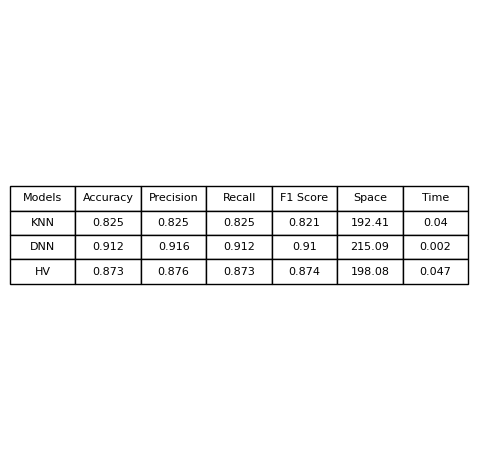

In [573]:
def create_table(data, headers):
    fig, ax = plt.subplots()

    table = ax.table(cellText=data, colLabels=headers, cellLoc="center", loc="center", colWidths=[0.2]*len(headers))
    table.auto_set_font_size(True)
    table.set_fontsize(14)
    table.scale(1.2, 1.2)

    ax.axis("off")
    fig.tight_layout()
    plt.show()


table_data = [
    ["KNN", round(knn_accuracy,3), round(knn_precision,3), round(knn_recall,3), round(knn_f1,3), round(knnspace,2), round(knntime,2)],
    ["DNN", round(dnn_accuracy,3), round(dnn_precision,3), round(dnn_recall,3), round(dnn_f1,3), round(dnnspace,2), round(dnntime,3)],
    ["HV", round(ensemble_accuracy,3), round(ensemble_precision,3), round(ensemble_recall,3), round(ensemble_f1,3), round(hvspace,2), round(hvtime,3)],
]

table_headers = ["Models", "Accuracy", "Precision", 'Recall', 'F1 Score','Space','Time']

create_table(table_data, table_headers)